## Spatiotemporal Forecasting + Interpolation w/ GPR

Take everything seen so far, and predict P1 and P2 on a regular grid over Berlin at a future timestamp using a spatiotemporal Gaussian Process.

In [1]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


BBOX = {
    "lat_min": 52.3383,
    "lat_max": 52.6755,
    "lon_min": 13.0884,
    "lon_max": 13.7612,
}

### Data ingest

In [2]:
# ----------------------------
# Hyperparameters
# ----------------------------
LOOKBACK_DAYS = 21         # rolling lookback window in days
TEMP_HORIZON_HOURS = 1     # how far ahead to predict
SPATIAL_TEST_FRAC = 0.2    # fraction of locations held out for spatial test

# ----------------------------
# Read data
# ----------------------------
df = pd.read_parquet("../data/2024-citsci-pollutants-hourly.parquet")

# Ensure datetime
df['timestamp_hour'] = pd.to_datetime(df['timestamp_hour'])

# Aggregate PM2.5 per sensor/location + hour
df = df.groupby(['lat', 'lon', 'timestamp_hour'], as_index=False)['PM2_5'].mean()

# ----------------------------
# Rolling lookback
# ----------------------------
latest_time = df['timestamp_hour'].max()
start_time = latest_time - pd.Timedelta(days=LOOKBACK_DAYS)
df_recent = df[df['timestamp_hour'] >= start_time].copy()

# ----------------------------
# Spatio-temporal train/test split
# ----------------------------

# Select spatial test locations
unique_locations = df_recent[['lat', 'lon']].drop_duplicates()
num_test_locations = int(len(unique_locations) * SPATIAL_TEST_FRAC)
test_locations = unique_locations.sample(n=num_test_locations, random_state=42)

# Temporal split
train_end_time = latest_time - pd.Timedelta(hours=TEMP_HORIZON_HOURS)

# Training set: before temporal horizon AND not in spatial test locations
train_df = df_recent[
    (df_recent['timestamp_hour'] <= train_end_time) &
    (~df_recent.set_index(['lat', 'lon']).index.isin(test_locations.set_index(['lat', 'lon']).index))
].copy()

# Test set: either in spatial test locations OR after temporal horizon
test_df = df_recent[
    (df_recent['timestamp_hour'] > train_end_time) |
    (df_recent.set_index(['lat', 'lon']).index.isin(test_locations.set_index(['lat', 'lon']).index))
].copy()

# ----------------------------
# Convert time to minutes since start (relative to training start)
# ----------------------------
train_start_time = train_df['timestamp_hour'].min()
train_df['minutes_since_start'] = (train_df['timestamp_hour'] - train_start_time).dt.total_seconds() / 60
test_df['minutes_since_start'] = (test_df['timestamp_hour'] - train_start_time).dt.total_seconds() / 60

# ----------------------------
# Features & targets
# ----------------------------
X_train = train_df[['lat','lon','minutes_since_start']].values
y_train = train_df['PM2_5'].values
X_test = test_df[['lat','lon','minutes_since_start']].values
y_test = test_df['PM2_5'].values

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ----------------------------
# Device
# ----------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------
# Scale features and targets
# ----------------------------
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = torch.tensor(scaler_X.transform(X_train), dtype=torch.float32).to(device)
X_test_scaled = torch.tensor(scaler_X.transform(X_test), dtype=torch.float32).to(device)

scaler_y = StandardScaler().fit(y_train.reshape(-1,1))
y_train_scaled = torch.tensor(scaler_y.transform(y_train.reshape(-1,1)), dtype=torch.float32).squeeze().to(device)
y_test_scaled = torch.tensor(scaler_y.transform(y_test.reshape(-1,1)), dtype=torch.float32).squeeze().to(device)

Train shape: (68856, 3) (68856,)
Test shape: (18058, 3) (18058,)


In [6]:
class SpatioTemporalGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=3)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Instantiation

In [7]:
# ----------------------------
# Inducing points (subset of training data)
# ----------------------------
num_inducing = min(500, X_train_scaled.shape[0])  # adjust depending on GPU memory
inducing_points = X_train_scaled[torch.randperm(X_train_scaled.size(0))[:num_inducing]]

# ----------------------------
# Model + Likelihood
# ----------------------------
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = SpatioTemporalGP(inducing_points).to(device)

# ----------------------------
# Training hyperparameters
# ----------------------------
training_iterations = 300
learning_rate = 0.01

# ----------------------------
# Optimizer
# ----------------------------
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=learning_rate)

# ----------------------------
# Loss (ELBO)
# ----------------------------
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train_scaled.size(0))

### Train Loop

In [8]:
# ----------------------------
# Training loop - Need a larger GPU!
# ----------------------------
model.train()
likelihood.train()

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_scaled)
    loss = -mll(output, y_train_scaled)
    loss.backward()
    if (i+1) % 50 == 0:
        print(f"Iter {i+1}/{training_iterations} - Loss: {loss.item():.4f}")
    optimizer.step()

Iter 50/300 - Loss: 1.4141
Iter 100/300 - Loss: 1.3739
Iter 150/300 - Loss: 1.3210
Iter 200/300 - Loss: 1.1985
Iter 250/300 - Loss: 0.8185
Iter 300/300 - Loss: 0.2810


Test RMSE: 59.221
Test R²: -48.263


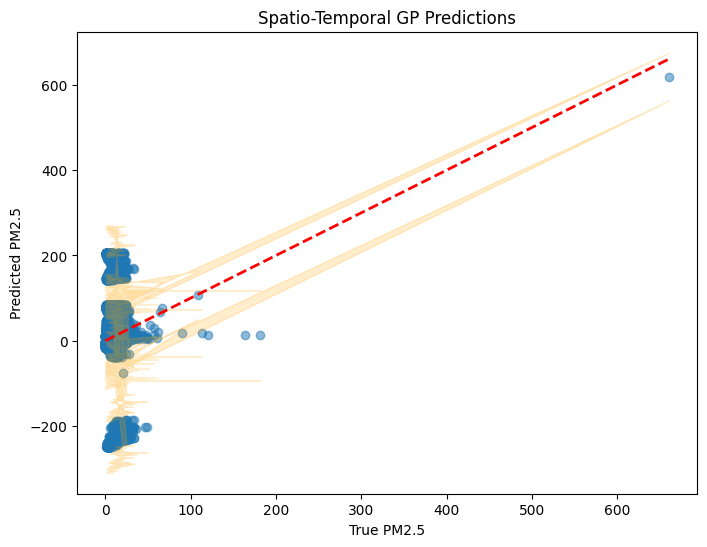

In [9]:
# ----------------------------
# Evaluation
# ----------------------------
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(X_test_scaled))
    mean_preds = preds.mean
    lower, upper = preds.confidence_region()

# Unscale predictions and true values
mean_preds_unscaled = scaler_y.inverse_transform(mean_preds.cpu().numpy().reshape(-1,1)).squeeze()
lower_unscaled = scaler_y.inverse_transform(lower.cpu().numpy().reshape(-1,1)).squeeze()
upper_unscaled = scaler_y.inverse_transform(upper.cpu().numpy().reshape(-1,1)).squeeze()
y_test_unscaled = scaler_y.inverse_transform(y_test_scaled.cpu().numpy().reshape(-1,1)).squeeze()

# ----------------------------
# Metrics
# ----------------------------
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_unscaled, mean_preds_unscaled))
r2 = r2_score(y_test_unscaled, mean_preds_unscaled)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

# ----------------------------
# Optional plot
# ----------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test_unscaled, mean_preds_unscaled, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()],
         [y_test_unscaled.min(), y_test_unscaled.max()],
         'r--', lw=2)
plt.fill_between(y_test_unscaled, lower_unscaled, upper_unscaled, color='orange', alpha=0.2)
plt.xlabel("True PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Spatio-Temporal GP Predictions")
plt.show()

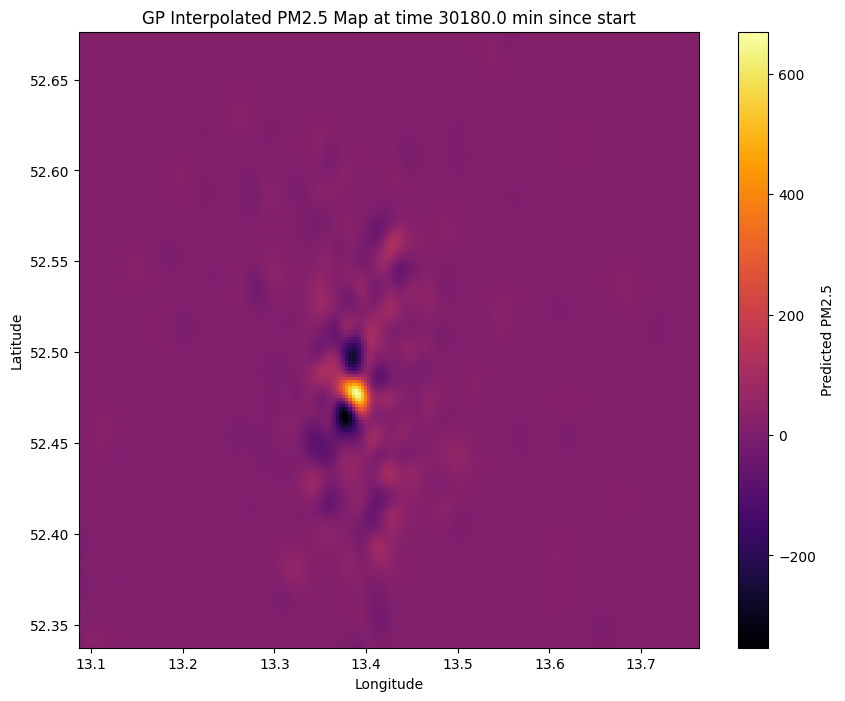

In [11]:
# Choose the time for the map (e.g., last training timestamp)
map_time = train_df['minutes_since_start'].max()
map_time_tensor = torch.tensor([map_time], dtype=torch.float32).to(device)

# Create a regular grid of lat/lon
grid_lon = np.linspace(BBOX['lon_min'], BBOX['lon_max'], 200)
grid_lat = np.linspace(BBOX['lat_min'], BBOX['lat_max'], 200)
grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

# Flatten the grid
grid_coords = np.column_stack([
    grid_lat_mesh.ravel(),
    grid_lon_mesh.ravel(),
    np.full(grid_lat_mesh.size, map_time)  # temporal feature
])

# Scale features
grid_coords_scaled = torch.tensor(scaler_X.transform(grid_coords), dtype=torch.float32).to(device)

# Predict with GP
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(grid_coords_scaled))
    mean_pred = pred_dist.mean
    lower, upper = pred_dist.confidence_region()

# Unscale predictions
mean_pred_unscaled = scaler_y.inverse_transform(mean_pred.cpu().numpy().reshape(-1,1)).squeeze()
lower_unscaled = scaler_y.inverse_transform(lower.cpu().numpy().reshape(-1,1)).squeeze()
upper_unscaled = scaler_y.inverse_transform(upper.cpu().numpy().reshape(-1,1)).squeeze()

# Reshape back to grid
mean_grid = mean_pred_unscaled.reshape(grid_lat_mesh.shape)
lower_grid = lower_unscaled.reshape(grid_lat_mesh.shape)
upper_grid = upper_unscaled.reshape(grid_lat_mesh.shape)

# Plot
plt.figure(figsize=(10,8))
plt.pcolormesh(grid_lon_mesh, grid_lat_mesh, mean_grid, cmap='inferno', shading='auto')
plt.colorbar(label='Predicted PM2.5')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'GP Interpolated PM2.5 Map at time {map_time:.1f} min since start')
plt.show()